
# Building fMRI encoding models for natural speech

Prepared by Kateryna Shapovalenko, kshapova@andrew.cmu.edu

**Goal:** This Jupyter Notebook is designed to build fMRI encoding models for natural speech as part of the CMU 10-733 course assignment. The goal is to analyze fMRI data and extract meaningful insights from it.

**Important note about this notebook:** The results of the most expensive computations (runtime >1 hour) are saved on the drive and uploaded again to this notebook. The lines of such code are commented out. See the comments. Feel free to uncomment if you want to rerun the notebook.

**Table of contents**:

- Installs
- Data loading and pre-processing
- Extracting stimuli features from a deep network (w/ language model)
- Aligning with the neural data
- Making the encoding model (w/ ridge regression)
- Interpreting the encoding model
- Comparing to other methods (w/ RSA)
- Conclusions
- References

**About data**: fMRI data from LeBel et al. (2023) -- a passive listening task of 8 subjects listening to the same 27 narrative stories (∼ 6 hours of data each). For the assignment, we'll analyze just 3 subjects:
- `sub-UTS01`
- `sub-UTS02`
- `sub-UTS03`

**Train/test split**:

- **Train**: 3 subjects listening to 8 stories:
    - `adollshouse`
    - `adventuresinsayingyes`
    - `afatherscover`
    - `againstthewind`
    - `alternateithicatom`
    - `task-avatar`
    - `backsideofthestorm`
    - `becomingindian`
- **Test**: 3 subjects listening to 1 story:
    - `wheretheressmoke`

**X/Y split**:
- **X**: aligned word embeddings (Time x Features)
- **Y**: fMRI data (Time x Voxels)

**Data formats**:

- **fMRI (pre-processed)**: `.hf5`
- **Audio**: `.wav`

## **Installs**

In [ ]:
!pip install -U setuptools wheel numpy cython
!pip install -U pycortex

In [ ]:
!pip install transformers librosa

In [ ]:
import sys
import os
from __future__ import print_function
import cortex
from cortex.options import config
import numpy as np
import h5py
import librosa
from transformers import GPT2Model, GPT2Tokenizer
import torch
import pickle
import scipy.interpolate
import scipy.signal
import matplotlib.pyplot as plt
from numpy.linalg import inv, svd
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge, RidgeCV
import time
from scipy.stats import zscore
import os.path
from pathlib import Path
import cortex
from cortex.options import config, configparser
from scipy.stats import pearsonr

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
sys.path.append('/content/drive/MyDrive/10733 - Neuro and AI/py_files_huth')
import textgrid
import stimulus_utils_new
import cross_validated_ridge_updated
from cross_validated_ridge_updated import SimpleCVRidgeDiffLambda

In [ ]:
!git config --global user.name "kshapovalenko"
!git config --global user.email "shapovalenko.kate@gmail.com"

In [ ]:
# Update the package lists
!apt-get update

# Try installing datalad again
!apt-get install -y datalad

# Clone the dataset repository using datalad
!datalad install https://github.com/OpenNeuroDatasets/ds003020.git

# Change directory to the cloned repository
%cd ds003020

## **Data loading and pre-processing**

In [ ]:
# Training stories
train_stories = [
    'adollshouse',
    'adventuresinsayingyes',
    'afatherscover',
    'againstthewind',
    'alternateithicatom',
    'avatar',
    'backsideofthestorm',
    'becomingindian']

# Test story
test_story = 'wheretheressmoke'

# Subjects
subjects = ['UTS01', 'UTS02', 'UTS03']

# Layer indices to extract embeddings from (layers 0, 3, and 10)
layer_indices = [0, 3, 10]

### fMRI data

In [ ]:
# This part takes ~1 hour to run.
"""
# Downloading .hf5 files for training stories for each subject
for subject in subjects:
    for story in train_stories:
        !datalad get derivative/preprocessed_data/{subject}/{story}.hf5

# Downloading .hf5 file for the test story for each subject
for subject in subjects:
    !datalad get derivative/preprocessed_data/{subject}/{test_story}.hf5
"""

In [ ]:
# All data from the previous step is loaded using h5py and saved on the drive.

"""
# Loading fMRI data for analysis using h5py

def load_data_from_hdf5(hdf5_path):
    with h5py.File(hdf5_path, 'r') as f:
        data = f['data'][:]
    return data

all_datasets = {}

# Load and store training data
for subject in subjects:
    for story in train_stories:
        hf5_path = f'derivative/preprocessed_data/{subject}/{story}.hf5'
        data_key = f'{subject}_{story}'
        all_datasets[data_key] = load_data_from_hdf5(hf5_path)

# Load and store test data
for subject in subjects:
    hf5_path = f'derivative/preprocessed_data/{subject}/{test_story}.hf5'
    data_key = f'{subject}_{test_story}'
    all_datasets[data_key] = load_data_from_hdf5(hf5_path)

# Now all_datasets dictionary contains all data. Access each dataset by its subject_story key
example_data = all_datasets['UTS01_adollshouse']

fmri_output_dir = '/content/drive/MyDrive/10733 - Neuro and AI/fmri_data'
os.makedirs(fmri_output_dir, exist_ok=True)

# Saving the entire fMRI data dictionary using pickle:
fmri_pickle_path = os.path.join(fmri_output_dir, 'fmri_data.pkl')
with open(fmri_pickle_path, 'wb') as f:
    pickle.dump(all_datasets, f)

# Saving each subject and story's fMRI Data as a separate numpy file:
for data_key in all_datasets:
    numpy_path = os.path.join(fmri_output_dir, f'{data_key}.npy')
    # Convert data to NumPy array if it's not already
    if isinstance(all_datasets[data_key], np.ndarray):
        data_array = all_datasets[data_key]
    else:
        data_array = np.array(all_datasets[data_key])
    np.save(numpy_path, data_array)
"""

In [ ]:
# Access the files with fMRI data

## Full file
fmri_output_dir = '/content/drive/MyDrive/10733 - Neuro and AI/fmri_data'
os.makedirs(fmri_output_dir, exist_ok=True)
fmri_pickle_path = os.path.join(fmri_output_dir, 'fmri_data.pkl')
with open(fmri_pickle_path, 'rb') as f:
    loaded_fmri_full_data = pickle.load(f)

## Test: individual files per subject per story
subject = 'UTS01'
story_name = 'adollshouse'
numpy_path = os.path.join(fmri_output_dir, f'{subject}_{story_name}.npy')
loaded_fmri_dataset = np.load(numpy_path)
loaded_fmri_dataset

array([[ 0.48287491,  1.49787759,  1.17956755, ...,  0.67717365,
         0.22272283,  0.28396711],
       [-0.58596608, -1.14946208, -0.64299088, ..., -0.73678742,
         0.81981527, -0.64548012],
       [ 0.24758547,  0.82852989, -0.26396463, ..., -0.27238346,
        -0.23775031,  0.15930151],
       ...,
       [ 1.69019163, -0.42824914,  0.20363944, ..., -0.79373416,
        -2.41088955, -0.37912233],
       [ 1.2970513 , -0.87799543, -1.08671173, ..., -0.59082702,
         0.77404707, -1.48487188],
       [ 1.12401627,  0.66287678, -1.69196696, ...,  0.36947555,
        -0.25121333, -0.44532832]])

In [ ]:
def print_fmri_shapes(all_datasets, subjects, train_stories, test_story):
    for subject in subjects:
        for story in train_stories + [test_story]:
            data_key = f'{subject}_{story}'
            data_shape = all_datasets[data_key].shape
            print(f"Subject: {subject}, Story: {story}, Shape: {data_shape}")

print_fmri_shapes(loaded_fmri_full_data, subjects, train_stories, test_story)

Subject: UTS01, Story: adollshouse, Shape: (241, 81126)
Subject: UTS01, Story: adventuresinsayingyes, Shape: (391, 81126)
Subject: UTS01, Story: afatherscover, Shape: (312, 81126)
Subject: UTS01, Story: againstthewind, Shape: (170, 81126)
Subject: UTS01, Story: alternateithicatom, Shape: (343, 81126)
Subject: UTS01, Story: avatar, Shape: (367, 81126)
Subject: UTS01, Story: backsideofthestorm, Shape: (345, 81126)
Subject: UTS01, Story: becomingindian, Shape: (388, 81126)
Subject: UTS01, Story: wheretheressmoke, Shape: (291, 81126)
Subject: UTS02, Story: adollshouse, Shape: (241, 94251)
Subject: UTS02, Story: adventuresinsayingyes, Shape: (391, 94251)
Subject: UTS02, Story: afatherscover, Shape: (312, 94251)
Subject: UTS02, Story: againstthewind, Shape: (170, 94251)
Subject: UTS02, Story: alternateithicatom, Shape: (343, 94251)
Subject: UTS02, Story: avatar, Shape: (367, 94251)
Subject: UTS02, Story: backsideofthestorm, Shape: (345, 94251)
Subject: UTS02, Story: becomingindian, Shape: (3

### Stories (audio/words) data

In [ ]:
"""
# Downloading .wav files for training stories
for story in train_stories:
    !datalad get stimuli/{story}.wav

# Downloading .wav file for the test story
!datalad get stimuli/{test_story}.wav
"""

In [ ]:
"""
# Loading audio data for analysis using librosa
def load_wav_file(wav_path):
    audio, sr = librosa.load(wav_path, sr=None) # sr=None ensures the audio is loaded in its original sampling rate
    return audio, sr

# Add audio data to the all_datasets dictionary
for story in train_stories + [test_story]:
    wav_path = f'stimuli/{story}.wav'
    audio_key = f'audio_{story}'
    audio, sr = load_wav_file(wav_path)
    all_datasets[audio_key] = {'audio': audio, 'sampling_rate': sr}

example_audio_data = all_datasets['audio_adollshouse']['audio']
example_sampling_rate = all_datasets['audio_adollshouse']['sampling_rate']
example_audio_data
"""

## **Extracting stimuli (stories) features from a deep network**

### Upload TextGrids files (phoneme and word-level transcripts)

In [ ]:
# Downloading TextGrids files (train and test)
for story in train_stories:
    !datalad get derivative/TextGrids/{story}.TextGrid

!datalad get derivative/TextGrids/{test_story}.TextGrid

### Extract words and end times from TextGrids files

In [ ]:
# Extract words from TextGrids files
textgrid_paths = [f'derivative/TextGrids/{story}.TextGrid' for story in train_stories + [test_story]]
DEFAULT_BAD_WORDS = frozenset(["sentence_start", "sentence_end", "br", "lg", "ls", "ns", "sp"])

def read_textgrid_filtered_words(file_path, bad_words=DEFAULT_BAD_WORDS):
    tg = textgrid.TextGrid.load(file_path)
    filtered_words = []
    end_times = []
    for tier in tg:
        if tier.nameid == 'word' and tier.classid == 'IntervalTier':
            for interval in tier.simple_transcript:
                word = interval[2].strip().lower()  # Convert to lowercase for consistent comparison
                if word and word not in bad_words:
                    filtered_words.append(word)
                    end_times.append(interval[1])
    return filtered_words, end_times

# Extracting filtered words and end times for each story
filtered_words_and_end_times = {story: read_textgrid_filtered_words(path) for story, path in zip(train_stories + [test_story], textgrid_paths)}

# Check the lengths and first few words after filtering
for story in train_stories + [test_story]:
    words, end_times = filtered_words_and_end_times[story]
    print(f"Story: {story}, Filtered Words: {len(words)}, End Times: {len(end_times)}, First few words: {words[:5]}")

Story: adollshouse, Filtered Words: 1657, End Times: 1657, First few words: ['alright', 'thank', 'you', 'very', 'much']
Story: adventuresinsayingyes, Filtered Words: 2319, End Times: 2319, First few words: ['i', 'first', 'started', 'taking', 'care']
Story: afatherscover, Filtered Words: 1182, End Times: 1182, First few words: ['good', 'evening', "i'm", 'the', 'first']
Story: againstthewind, Filtered Words: 870, End Times: 870, First few words: ['some', 'of', 'the', 'best', 'memories']
Story: alternateithicatom, Filtered Words: 2418, End Times: 2418, First few words: ["there're", 'some', 'scientists', 'who', 'say']
Story: avatar, Filtered Words: 1657, End Times: 1657, First few words: ['{ns}', 'tom', 'waits', 'loved', 'the']
Story: backsideofthestorm, Filtered Words: 1964, End Times: 1964, First few words: ["i'm", 'a', 'climber', 'which', 'is']
Story: becomingindian, Filtered Words: 2626, End Times: 2626, First few words: ['the', 'whole', 'family', 'was', 'there']
Story: wheretheressmok

In [ ]:
# Save the filtered words and end times into a pickle file
output_dir = '/content/drive/MyDrive/10733 - Neuro and AI/word_data'
os.makedirs(output_dir, exist_ok=True)

pickle_path = os.path.join(output_dir, 'filtered_words_and_end_times.pkl')
with open(pickle_path, 'wb') as f:
    pickle.dump(filtered_words_and_end_times, f)

### Create and test the embedding model (GPT2)

In [ ]:
# Initialize the model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2')
model.eval()

def get_contextual_embedding(story_words, layer_index, max_context_length=50):
    story_embeddings = []
    for idx in range(len(story_words)):

        # Create context window
        start_idx = max(0, idx - max_context_length)
        context_words = story_words[start_idx:idx+1]
        context_text = ' '.join(context_words)

        # Tokenize and get embeddings
        inputs = tokenizer(context_text, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
        hidden_states = outputs.hidden_states[layer_index]

        # Handle sub-word tokens: Average the embeddings of the last word's tokens
        word_embedding = hidden_states[:, -1, :].squeeze(0)  # Get embedding of the last word
        story_embeddings.append(word_embedding)

    # Stack embeddings to create a matrix
    return torch.stack(story_embeddings)

# Example usage for one story and one layer
#story_name = 'adollshouse'
#layer_index = 0
#story_words, _ = filtered_words_and_end_times[story_name]
#story_embeddings = get_contextual_embedding(story_words, layer_index)
#print(f"Story: {story_name}, Embeddings shape: {story_embeddings.shape}")

In [ ]:
# Function to calculate L2 norm distance between two words' embeddings
def calculate_distance(word1, word2, layer_index):
    embedding1 = get_contextual_embedding([word1], layer_index)[0]
    embedding2 = get_contextual_embedding([word2], layer_index)[0]
    return torch.norm(embedding1 - embedding2, p=2)

# Calculate distances at different layers
for layer_index in layer_indices:
    distance_tiger_lion = calculate_distance('tiger', 'lion', layer_index)
    distance_tiger_saturn = calculate_distance('tiger', 'saturn', layer_index)
    print(f"Layer {layer_index}: Tiger-Lion Distance: {distance_tiger_lion}, Tiger-Saturn Distance: {distance_tiger_saturn}")

Layer 0: Tiger-Lion Distance: 5.103525161743164, Tiger-Saturn Distance: 5.273309230804443
Layer 3: Tiger-Lion Distance: 39.4598274230957, Tiger-Saturn Distance: 41.389373779296875
Layer 10: Tiger-Lion Distance: 66.09916687011719, Tiger-Saturn Distance: 76.33308410644531


### Create embeddings for each word in each story

In [ ]:
# This part takes ~1 hour to run. All embeddings are saved on the drive.
"""
def process_stories_with_context(story_files, layer_indices, words_and_end_times):
    story_embeddings = {}
    for story_file in story_files:
        story_name = story_file.split('/')[-1].split('.')[0]
        words = words_and_end_times[story_name][0]
        story_embeddings[story_name] = {}
        for layer_index in layer_indices:
            story_layer_embeddings = get_contextual_embedding(words, layer_index)
            story_embeddings[story_name][layer_index] = story_layer_embeddings
    return story_embeddings

# Process stories and get embeddings with context
embeddings = process_stories_with_context(textgrid_paths, layer_indices, filtered_words_and_end_times)

# Ensure the directory exists
output_dir = '/content/drive/MyDrive/10733 - Neuro and AI/embeddings'
os.makedirs(output_dir, exist_ok=True)

# Saving the entire embeddings dictionary using pickle
pickle_path = os.path.join(output_dir, 'embeddings.pkl')
with open(pickle_path, 'wb') as f:
    pickle.dump(embeddings, f)

# Saving each layer of embeddings for each story as a separate numpy file
for story in embeddings:
    for layer in embeddings[story]:
        numpy_path = os.path.join(output_dir, f'embeddings_{story}_layer_{layer}.npy')
        # Convert PyTorch tensor to NumPy array if it's not already
        if isinstance(embeddings[story][layer], torch.Tensor):
            embeddings_array = embeddings[story][layer].numpy()
        else:
            embeddings_array = embeddings[story][layer]
        np.save(numpy_path, embeddings_array)
"""

In [ ]:
# Access the files with embeddings

## Full file
pickle_path = '/content/drive/MyDrive/10733 - Neuro and AI/embeddings/embeddings.pkl'
with open(pickle_path, 'rb') as f:
    loaded_embeddings = pickle.load(f)

## Individual files per story per layer
output_dir = '/content/drive/MyDrive/10733 - Neuro and AI/embeddings'
stories = train_stories + [test_story]  # This creates a flat list of story names
loaded_embeddings = {} # Initialize a dictionary to hold loaded embeddings
for story in stories: # Load each numpy file
    loaded_embeddings[story] = {}
    for layer in layer_indices:
        numpy_path = os.path.join(output_dir, f'embeddings_{story}_layer_{layer}.npy')
        loaded_embeddings[story][layer] = np.load(numpy_path)

# Test
#story_name = 'adollshouse'
#layer_index = 0
#specific_story_layer_embeddings = loaded_embeddings[story_name][layer_index]
#specific_story_layer_embeddings.shape

In [ ]:
# Check if the shapes match
for story in train_stories + [test_story]:
    story_words, story_end_times = filtered_words_and_end_times[story]
    num_filtered_words = len(story_words)
    num_end_times = len(story_end_times)
    #data_key = f'{subject}_{story}'
    #fmri_shape = loaded_fmri_full_data[data_key].shape
    for layer_index in layer_indices:
        embeddings_shape = loaded_embeddings[story][layer_index].shape
        print(f"Story: {story}, Layer: {layer_index}, Filtered Words: {num_filtered_words}, End Times: {num_end_times}, Embeddings Shape: {embeddings_shape}")

Story: adollshouse, Layer: 0, Filtered Words: 1657, End Times: 1657, Embeddings Shape: (1657, 768)
Story: adollshouse, Layer: 3, Filtered Words: 1657, End Times: 1657, Embeddings Shape: (1657, 768)
Story: adollshouse, Layer: 10, Filtered Words: 1657, End Times: 1657, Embeddings Shape: (1657, 768)
Story: adventuresinsayingyes, Layer: 0, Filtered Words: 2319, End Times: 2319, Embeddings Shape: (2319, 768)
Story: adventuresinsayingyes, Layer: 3, Filtered Words: 2319, End Times: 2319, Embeddings Shape: (2319, 768)
Story: adventuresinsayingyes, Layer: 10, Filtered Words: 2319, End Times: 2319, Embeddings Shape: (2319, 768)
Story: afatherscover, Layer: 0, Filtered Words: 1182, End Times: 1182, Embeddings Shape: (1182, 768)
Story: afatherscover, Layer: 3, Filtered Words: 1182, End Times: 1182, Embeddings Shape: (1182, 768)
Story: afatherscover, Layer: 10, Filtered Words: 1182, End Times: 1182, Embeddings Shape: (1182, 768)
Story: againstthewind, Layer: 0, Filtered Words: 870, End Times: 870, 

## **Aligning the word embeddings with the neural (fMRI) data**

### Check the shapes before alignment

In [ ]:
# Check if the shapes match
for story in train_stories + [test_story]:
    story_words, story_end_times = filtered_words_and_end_times[story]
    num_filtered_words = len(story_words)
    num_end_times = len(story_end_times)
    data_key = f'{subject}_{story}'
    fmri_shape = loaded_fmri_full_data[data_key].shape
    for layer_index in layer_indices:
        embeddings_shape = loaded_embeddings[story][layer_index].shape
        print(f"Story: {story}, Layer: {layer_index}, Filtered Words: {num_filtered_words}, End Times: {num_end_times}, Embeddings Shape: {embeddings_shape}, fMRI Shape: {fmri_shape}")

Story: adollshouse, Layer: 0, Filtered Words: 1657, End Times: 1657, Embeddings Shape: (1657, 768), fMRI Shape: (241, 81126)
Story: adollshouse, Layer: 3, Filtered Words: 1657, End Times: 1657, Embeddings Shape: (1657, 768), fMRI Shape: (241, 81126)
Story: adollshouse, Layer: 10, Filtered Words: 1657, End Times: 1657, Embeddings Shape: (1657, 768), fMRI Shape: (241, 81126)
Story: adventuresinsayingyes, Layer: 0, Filtered Words: 2319, End Times: 2319, Embeddings Shape: (2319, 768), fMRI Shape: (391, 81126)
Story: adventuresinsayingyes, Layer: 3, Filtered Words: 2319, End Times: 2319, Embeddings Shape: (2319, 768), fMRI Shape: (391, 81126)
Story: adventuresinsayingyes, Layer: 10, Filtered Words: 2319, End Times: 2319, Embeddings Shape: (2319, 768), fMRI Shape: (391, 81126)
Story: afatherscover, Layer: 0, Filtered Words: 1182, End Times: 1182, Embeddings Shape: (1182, 768), fMRI Shape: (312, 81126)
Story: afatherscover, Layer: 3, Filtered Words: 1182, End Times: 1182, Embeddings Shape: (1

### Align the embeddings with fMRI

In [ ]:
# Support functions for aligning embeddings with fMRI data

def trim_embeddings(embeddings, trim_start=10, trim_end=10): # Trim the first `trim_start` and last `trim_end` time points
    """
    According to the authors: to avoid artifacts from onset transients and poor detrending performance at the edges of the data,
    responses were trimmed by removing 20 seconds (10 volumes) at the beginning and end of each scan.
    """
    return embeddings[trim_start:-trim_end, :]

def lanczos_resample(embeddings, end_times, target_times): # Resample embeddings to align with target times using Lanczos resampling.

    M = embeddings.shape[1]  # Number of features in embeddings
    resampled_embeddings = np.zeros((len(target_times), M))

    for i in range(M):
      resampled_signal, _ = scipy.signal.resample(embeddings[:, i], len(target_times), t=end_times, window=('kaiser', 14))
      resampled_embeddings[:, i] = resampled_signal

    return resampled_embeddings

def concatenate_previous_embeddings(embeddings, num_prev=5): # Concatenate embeddings with features from previous timepoints.

    M = embeddings.shape[1]  # Number of features in embeddings
    extended_embeddings = np.zeros((embeddings.shape[0], M * (num_prev + 1)))

    for i in range(embeddings.shape[0]):
        for j in range(num_prev + 1):
            idx = max(i - j, 0)
            extended_embeddings[i, j * M:(j + 1) * M] = embeddings[idx, :]

    return extended_embeddings

def normalize_embeddings(embeddings): #  Normalize embeddings per story

    return embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

output_dir = '/content/drive/MyDrive/10733 - Neuro and AI/aligned_embeddings'
processed_embeddings_dict = {}

# For each story and layer, process the embeddings
for story in train_stories + [test_story]:
    story_words, story_end_times = filtered_words_and_end_times[story]
    fmri_data = loaded_fmri_full_data[f'UTS01_{story}']
    fmri_times = np.linspace(0, fmri_data.shape[0], fmri_data.shape[0])

    story_end_times = np.asarray(story_end_times, dtype=float)
    fmri_times = np.asarray(fmri_times, dtype=float)

    for layer_index in layer_indices:

        # 0. Get original embeddings: (1657, 768)
        embeddings = loaded_embeddings[story][layer_index]

        # 1. Trim embeddings to match fMRI data: (1657, 768) --> (1637, 768); removed 20 timesteps (-10 at start; -10 at the end)
        trimmed_embeddings = trim_embeddings(embeddings)

        # 2. Apply Lanczos resampling:  (1637, 768) --> (241, 768); reduced the T to match fMRI
        resampled_embeddings = lanczos_resample(embeddings, story_end_times, fmri_times)

        # 3. Concatenate previous embeddings: (241, 768) --> (241, 4608); increased features [number of features × (num_prev + 1)])
        extended_embeddings = concatenate_previous_embeddings(resampled_embeddings)

        # 4. Normalize embeddings per story: (241, 4608) --> (241, 4608); no change to the shape
        normalized_embeddings = normalize_embeddings(extended_embeddings)

        # 5.1 Save the aligned embeddings as one file
        processed_embeddings_dict[f'{story}_layer_{layer_index}'] = normalized_embeddings

        # 5.2 Save the aligned embeddings in individual files
        processed_embeddings_path = os.path.join(output_dir, f'processed_embeddings_{story}_layer_{layer_index}.npy')
        np.save(processed_embeddings_path, normalized_embeddings)

pickle_path = os.path.join(output_dir, 'processed_embeddings.pkl')
with open(pickle_path, 'wb') as f:
  pickle.dump(processed_embeddings_dict, f)

In [ ]:
# Upload the aligned embeddings and print their shapes to make sure that now embeddings and fmri are aligned
for story in train_stories + [test_story]:
    for layer_index in layer_indices:
        file_path = os.path.join(output_dir, f'processed_embeddings_{story}_layer_{layer_index}.npy')
        if os.path.exists(file_path):
            loaded_aligned_embeddings = np.load(file_path)
            fmri_data = loaded_fmri_full_data[f'UTS01_{story}']
            print(f"Story: {story}, Layer: {layer_index}, Embeddings Shape: {loaded_aligned_embeddings.shape}, fMRI Shape: {fmri_data.shape}")
        else:
            print(f"File not found: {file_path}")

Story: adollshouse, Layer: 0, Embeddings Shape: (241, 4608), fMRI Shape: (241, 81126)
Story: adollshouse, Layer: 3, Embeddings Shape: (241, 4608), fMRI Shape: (241, 81126)
Story: adollshouse, Layer: 10, Embeddings Shape: (241, 4608), fMRI Shape: (241, 81126)
Story: adventuresinsayingyes, Layer: 0, Embeddings Shape: (391, 4608), fMRI Shape: (391, 81126)
Story: adventuresinsayingyes, Layer: 3, Embeddings Shape: (391, 4608), fMRI Shape: (391, 81126)
Story: adventuresinsayingyes, Layer: 10, Embeddings Shape: (391, 4608), fMRI Shape: (391, 81126)
Story: afatherscover, Layer: 0, Embeddings Shape: (312, 4608), fMRI Shape: (312, 81126)
Story: afatherscover, Layer: 3, Embeddings Shape: (312, 4608), fMRI Shape: (312, 81126)
Story: afatherscover, Layer: 10, Embeddings Shape: (312, 4608), fMRI Shape: (312, 81126)
Story: againstthewind, Layer: 0, Embeddings Shape: (170, 4608), fMRI Shape: (170, 81126)
Story: againstthewind, Layer: 3, Embeddings Shape: (170, 4608), fMRI Shape: (170, 81126)
Story: ag

In [ ]:
# Process the fMRI data to a neural data matrix of size Time × N.

"""
No addiitonal action is needed.
According to the professor's comment, our already contains the masked version (number of TRs * number of voxels). It is not in 4D form.
This corresponds to the thick mask in pycortex: cortex.db.get_mask(surface_name, transform_name, "thick").
Since the data is already masked, we would only need the mask if it's required for plotting.
Pycortex should figure it out though without the mask.
"""

### Visualize the results

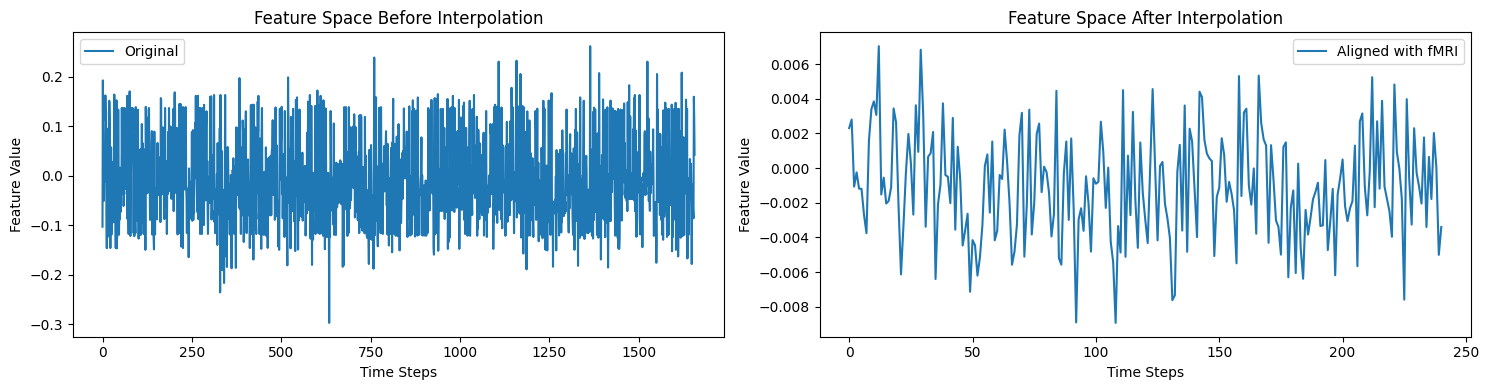

In [ ]:
# Let's use the data for one of the stories (e.g., "adollshouse") and one of the layers (e.g., Layer 0) as an example
# Load original and aligned embeddings for "adollshouse" story and Layer 0
original_embeddings_path = '/content/drive/MyDrive/10733 - Neuro and AI/embeddings/embeddings_adollshouse_layer_0.npy'
aligned_embeddings_path = '/content/drive/MyDrive/10733 - Neuro and AI/aligned_embeddings/processed_embeddings_adollshouse_layer_0.npy'

# Check if the paths are correct and the files exist
if os.path.exists(original_embeddings_path) and os.path.exists(aligned_embeddings_path):
    original_embeddings = np.load(original_embeddings_path)
    aligned_embeddings = np.load(aligned_embeddings_path)

    # Select the first dimension of the feature space for plotting
    original_feature = original_embeddings[:, 0]
    aligned_feature = aligned_embeddings[:, 0]

    # Plotting the first dimension of the feature space before and after interpolation
    plt.figure(figsize=(15, 4))

    # Before interpolation
    plt.subplot(1, 2, 1)
    plt.plot(original_feature, label="Original")
    plt.title("Feature Space Before Interpolation")
    plt.xlabel("Time Steps")
    plt.ylabel("Feature Value")
    plt.legend()

    # After interpolation
    plt.subplot(1, 2, 2)
    plt.plot(aligned_feature, label="Aligned with fMRI")
    plt.title("Feature Space After Interpolation")
    plt.xlabel("Time Steps")
    plt.ylabel("Feature Value")
    plt.legend()

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/10733 - Neuro and AI/charts/embeddings_comparision.png')
    plt.show()

    # Report shapes
    original_shape = original_embeddings.shape
    aligned_shape = aligned_embeddings.shape

    original_shape, aligned_shape
else:
    print("File not found. Please check the file paths.")

## **Making the encoding model (ridge regression)**

### Load data (aligned embeddings and fMRI)

In [ ]:
# Get aligned embeddings data
aligned_embeddings_path = '/content/drive/MyDrive/10733 - Neuro and AI/aligned_embeddings/processed_embeddings.pkl'
with open(aligned_embeddings_path, 'rb') as f:
    loaded_aligned_embeddings = pickle.load(f)

# Get fMRI data
fmri_pickle_path = '/content/drive/MyDrive/10733 - Neuro and AI/fmri_data/fmri_data.pkl'
with open(fmri_pickle_path, 'rb') as f:
    loaded_fmri_full_data = pickle.load(f)

In [ ]:
# Check types and keys

# For aligned embeddings
print("loaded_aligned_embeddings:")
print("type:", type(loaded_aligned_embeddings))
if isinstance(loaded_aligned_embeddings, dict):
    print("keys:", loaded_aligned_embeddings.keys())

# For fMRI data
print("\nloaded_fmri_full_data:")
print("type:", type(loaded_fmri_full_data))
if isinstance(loaded_fmri_full_data, dict):
    print("keys:", loaded_fmri_full_data.keys())

loaded_aligned_embeddings:
type: <class 'dict'>
keys: dict_keys(['adollshouse_layer_0', 'adollshouse_layer_3', 'adollshouse_layer_10', 'adventuresinsayingyes_layer_0', 'adventuresinsayingyes_layer_3', 'adventuresinsayingyes_layer_10', 'afatherscover_layer_0', 'afatherscover_layer_3', 'afatherscover_layer_10', 'againstthewind_layer_0', 'againstthewind_layer_3', 'againstthewind_layer_10', 'alternateithicatom_layer_0', 'alternateithicatom_layer_3', 'alternateithicatom_layer_10', 'avatar_layer_0', 'avatar_layer_3', 'avatar_layer_10', 'backsideofthestorm_layer_0', 'backsideofthestorm_layer_3', 'backsideofthestorm_layer_10', 'becomingindian_layer_0', 'becomingindian_layer_3', 'becomingindian_layer_10', 'wheretheressmoke_layer_0', 'wheretheressmoke_layer_3', 'wheretheressmoke_layer_10'])

loaded_fmri_full_data:
type: <class 'dict'>
keys: dict_keys(['UTS01_adollshouse', 'UTS01_adventuresinsayingyes', 'UTS01_afatherscover', 'UTS01_againstthewind', 'UTS01_alternateithicatom', 'UTS01_avatar', 'UT

### Pre-process data (split into X/Y and train/test)

In [ ]:
X_train = {}
Y_train = {}
X_test = {}
Y_test = {}

for subject in subjects:
    X_train[subject] = {}
    Y_train[subject] = {}
    X_test[subject] = {}
    Y_test[subject] = {}

    for layer_index in layer_indices:
        X_train[subject][layer_index] = {}
        Y_train[subject][layer_index] = {}

        for story in train_stories:
            embeddings_key = f"{story}_layer_{layer_index}"
            fmri_key = f"{subject}_{story}"

            X_train[subject][layer_index][story] = loaded_aligned_embeddings[embeddings_key]
            Y_train[subject][layer_index][story] = loaded_fmri_full_data[fmri_key]

        # Test data
        X_test[subject][layer_index] = loaded_aligned_embeddings[f"{test_story}_layer_{layer_index}"]
        Y_test[subject][layer_index] = loaded_fmri_full_data[f"{subject}_{test_story}"]

In [ ]:
# Double-check that everything is correct

# Example train: word embeddings
x_train = X_train['UTS01'][3]['adollshouse'].shape # subject 'UTS01', layer 3, story 'adollshouse'

# Example train: fMRI (we still include layer as a parameter but the data is the same across layers)
y_train = Y_train['UTS01'][3]['adollshouse'].shape # subject 'UTS01', layer 3, story 'adollshouse'

# Example test: word embeddings
x_test = X_test['UTS01'][3].shape # subject 'UTS01', layer 3, just one story available

# Example test: fMRI
y_test = Y_test['UTS01'][3].shape # subject 'UTS01', layer 3, just one story available

print(x_train) # time x features (number of features is the same across all subjects/stories = 4608)
print(y_train) # time x voxels (number of voxels is the same across all subjects/stories = 81126)
print(x_test) # time x features
print(y_test) # time x voxels

(241, 4608)
(241, 81126)
(291, 4608)
(291, 81126)


### Fit the model

In [ ]:
# Runs for 30 mins on A100 + High-RAM. Modelling results are saved on drive.

"""
# Utils
def corr(X, Y):
    return np.mean(zscore(X) * zscore(Y), 0)

def R2(Pred, Real):
    SSres = np.mean((Real - Pred) ** 2, 0)
    SStot = np.var(Real, 0)
    return np.nan_to_num(1 - SSres / SStot)

# Dictionary to store results
results = {}

for subject in subjects:

    results[subject] = {}

    for layer_index in layer_indices:

        print(f"Processing subject {subject}, layer {layer_index}")

        # Combine training data across stories for this subject and layer
        X_train_combined = np.concatenate([X_train[subject][layer_index][story] for story in train_stories], axis=0)
        Y_train_combined = np.concatenate([Y_train[subject][layer_index][story] for story in train_stories], axis=0)

        # Initialize the model
        ridge_model = SimpleCVRidgeDiffLambda(n_splits=2,
                                              lambdas=np.array([10 ** i for i in range(-6, 7, 2)]),
                                              solver = 'saga') # default: (n_splits=10,lambdas=np.array([10 ** i for i in range(-6, 10)]), solver = 'auto')

        # Train the model
        weights, chosen_lambda, cv_scores = ridge_model.fit(X_train_combined, Y_train_combined)

        # Test data for this subject and layer
        X_test_layer = X_test[subject][layer_index]
        Y_test_layer = Y_test[subject][layer_index]

        # Make predictions
        Y_pred = ridge_model.predict(X_test_layer)

        # Evaluate (R2 and correlation coeficient)
        test_R2 = R2(Y_pred, Y_test_layer)
        test_corr_coef = corr(Y_pred, Y_test_layer)

        # Store results
        results[subject][layer_index] = {
            "weights": weights,
            "chosen_lambda": chosen_lambda,
            "Y_pred": Y_pred,
            "test_R2": test_R2,
            "test_corr_coef": test_corr_coef,
            "cv_scores": cv_scores}

# Specify the file path and name
file_path = '/content/drive/MyDrive/10733 - Neuro and AI/ridge_results.pkl'

# Save the dictionary into a pickle file
with open(file_path, 'wb') as file:
    pickle.dump(results, file)
"""

Processing subject UTS01, layer 0
Processing subject UTS01, layer 3
Processing subject UTS01, layer 10
Processing subject UTS02, layer 0
Processing subject UTS02, layer 3
Processing subject UTS02, layer 10
Processing subject UTS03, layer 0
Processing subject UTS03, layer 3
Processing subject UTS03, layer 10


### Load the results back

In [ ]:
file_path = '/content/drive/MyDrive/10733 - Neuro and AI/ridge_results.pkl'
with open(file_path, 'rb') as f:
    loaded_ridge_results = pickle.load(f) # The file is ~30GB. Takes ~7-10 mins to upload

In [ ]:
# Double-check that everything is correct

# Example weights
weights = loaded_ridge_results['UTS01'][3]['weights'] # subject 'UTS01', layer 3

# Example chosen_lambda
chosen_lambda = loaded_ridge_results['UTS01'][3]['chosen_lambda']

# Example Y_pred
Y_pred = loaded_ridge_results['UTS01'][3]['Y_pred']

# Example test_R2
test_R2 = loaded_ridge_results['UTS01'][3]['test_R2']

# Example test_corr_coef
test_corr_coef = loaded_ridge_results['UTS01'][3]['test_corr_coef']

# Example cv_scores
cv_scores = loaded_ridge_results['UTS01'][3]['cv_scores'] # 7-fold cross-validation

print('weights', weights.shape)
print('chosen_lambda', chosen_lambda.shape)
print('Y_pred', Y_pred.shape)
print('test_R2', test_R2.shape)
print('test_corr_coef', test_corr_coef.shape)
print('cv_scores', cv_scores.shape)

weights (4608, 81126)
chosen_lambda (81126,)
Y_pred (291, 81126)
test_R2 (81126,)
test_corr_coef (81126,)
cv_scores (7, 81126)


### Set up everything for visualization

In [ ]:
!datalad get derivative/pycortex-db

In [ ]:
print(config.get('basic', 'filestore'))

/content/ds003020/derivative/pycortex-db


In [ ]:
config_file_path = cortex.options.usercfg
config = configparser.ConfigParser()
config.read(config_file_path)
new_filestore_path = '/content/ds003020/derivative/pycortex-db' # Update the filestore path
config.set('basic', 'filestore', new_filestore_path)
with open(config_file_path, 'w') as configfile: # Write the updated configuration back to the file
    config.write(configfile)
config.read(config_file_path) # Verify the update
print(config.get('basic', 'filestore'))

/content/ds003020/derivative/pycortex-db


In [ ]:
os.path.exists(config.get('basic', 'filestore')) # Restart the session and verify the path

True

In [ ]:
print(os.listdir(cortex.database.default_filestore)) # Check the subjects in the directory
cortex.database.db.subjects

['UTS05', 'UTS03', 'UTS07', 'UTS01', 'UTS02', 'UTS06', 'UTS08', 'UTS04']


{'UTS05': <cortex.database.SubjectDB at 0x7e9b4288e890>,
 'UTS03': <cortex.database.SubjectDB at 0x7e9b4288ecb0>,
 'UTS07': <cortex.database.SubjectDB at 0x7e9b4288ffd0>,
 'UTS01': <cortex.database.SubjectDB at 0x7e9b4288f4c0>,
 'UTS02': <cortex.database.SubjectDB at 0x7e9a584ff310>,
 'UTS06': <cortex.database.SubjectDB at 0x7e9a584ff820>,
 'UTS08': <cortex.database.SubjectDB at 0x7e9a584ff760>,
 'UTS04': <cortex.database.SubjectDB at 0x7e9a584ff0a0>}

In [ ]:
cortex.database.db.UTS01.surfaces # Check the data for each subject

Surfaces: [pia, wm, inflated, flat]

### Visualize the results

In [ ]:
# Check the range of values

min_corr_coef = float('inf')
max_corr_coef = float('-inf')
all_corr_coefs = []

for subject, layers in loaded_ridge_results.items():
    for layer_index, data in layers.items():
        corr_coef = data['test_corr_coef']
        all_corr_coefs.extend(corr_coef)
        min_corr_coef = min(min_corr_coef, corr_coef.min())
        max_corr_coef = max(max_corr_coef, corr_coef.max())

# Convert to numpy array for easy calculation
all_corr_coefs = np.array(all_corr_coefs)

# Adjust min and max by removing 1 standard deviation
#mean_corr_coef = np.mean(all_corr_coefs)
#std_corr_coef = np.std(all_corr_coefs)
#adjusted_min_corr_coef = mean_corr_coef - std_corr_coef
#adjusted_max_corr_coef = mean_corr_coef + std_corr_coef

min_corr_coef_final = min_corr_coef*(0.047)
max_corr_coef_final = max_corr_coef

min_corr_coef, max_corr_coef, min_corr_coef_final, max_corr_coef_final

(-0.47375563293877265,
 0.5996744863795925,
 -0.022266514748122315,
 0.5996744863795925)

In [ ]:
# Test result for just on example
#corr_coef = loaded_ridge_results['UTS01'][0]['test_corr_coef']
#mask = cortex.db.get_mask('UTS01', 'UTS01_auto', 'thick')
#vol_FT = cortex.Volume(corr_coef, 'UTS01', 'UTS01_auto', mask=mask, vmin=0, vmax=0.6, cmap='viridis')
#fig = cortex.quickflat.make_figure(vol_FT, with_rois= False, height=500)
#plt.title("prediction performance with semantic features\n FastText\n (correlation)", fontsize=20);

In [ ]:
# Chart 1
"""
Deliver: Provide a per-subject plot of test set encoding prediction correlation against
regularization coefficient for each of the proposed feature spaces.
Important: these plots should be a brain plot using the cortex.quickflat.make figure function,
and you should use the same minimum and maximum values (vmin and vmax),
and you should choose a colormap judiciously. If you’re plotting a positive range only,
use a one-directional colormap. If you’re plotting negative and positive values, choose a divergent colormap.
Justify in one sentence your choice of a colormap.
Give each plot a title and a colorbar (the pycortex plotting function includes the option of a colorbar as an argument)
and summarize the trends in your figures.
"""

file_path = '/content/drive/MyDrive/10733 - Neuro and AI/charts'

for subject in subjects:
    for layer_index in layer_indices:
        corr_coef = loaded_ridge_results[subject][layer_index]['test_corr_coef']
        xfmname = f"{subject}_auto"
        mask = cortex.db.get_mask(subject, xfmname, 'thick')
        vol_FT = cortex.Volume(corr_coef, subject, xfmname, mask=mask,
                               vmin=min_corr_coef_final, vmax=max_corr_coef_final,
                               cmap='viridis', colorbar=True) # coolwarm
        fig = cortex.quickflat.make_figure(vol_FT, with_rois= False, height=500)
        plt.title(f"Subject: {subject}, Layer: {layer_index}")
        plt.savefig(f"{file_path}/corr_plot_{subject}_{layer_index}.png")
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

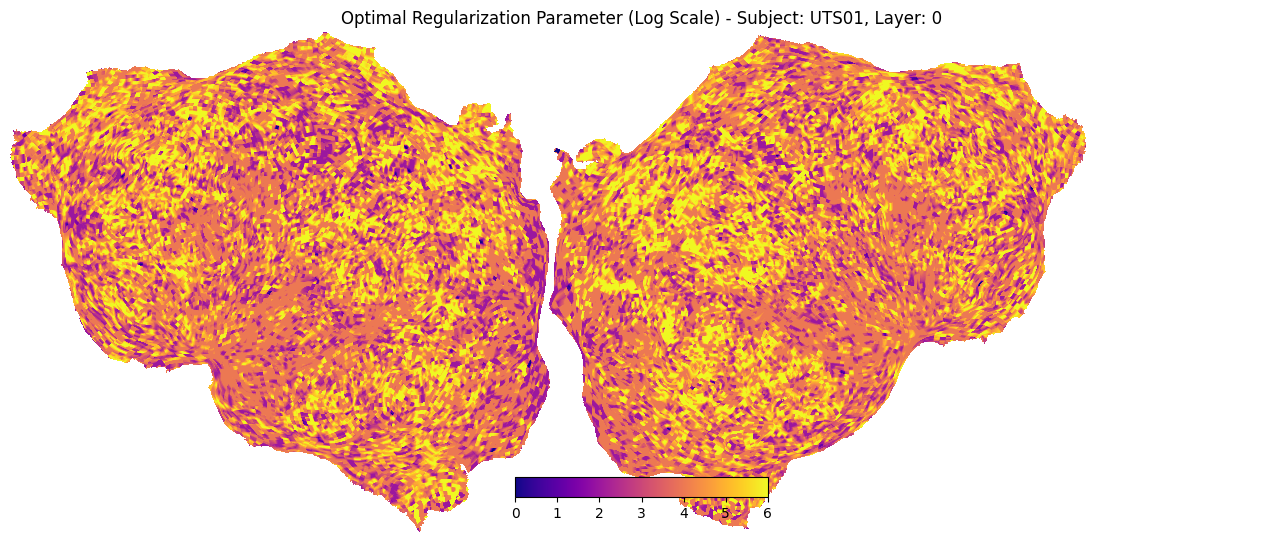

In [ ]:
# Chart 2
"""
Then, for one of the subjects, and one of the feature spaces, make a brain plot of the optimal regularization parameter.
You might want to look into converting the parameter into a log scale. Include a colorbar and choose a different colormap,
justifying the selection in one line.
"""

# For one subject and one layer, create a plot of the optimal regularization parameter
subject = 'UTS01'
layer_index = 0
chosen_lambda = loaded_ridge_results[subject][layer_index]['chosen_lambda']
log_lambda = np.log10(chosen_lambda)

# Set transformation name
xfmname = f"{subject}_auto"

# Get the appropriate mask
mask = cortex.db.get_mask(subject, xfmname, 'thick')

# Create a Volume object for visualization
vol_lambda = cortex.Volume(log_lambda, subject, xfmname, mask=mask,
                           vmin=log_lambda.min(), vmax=log_lambda.max(),
                           cmap='plasma', colorbar=True)  # 'plasma' colormap for perceptual uniformity

# Generate the plot
fig = cortex.quickflat.make_figure(vol_lambda, with_rois=False, height=500)
plt.title(f"Optimal Regularization Parameter (Log Scale) - Subject: {subject}, Layer: {layer_index}")
plt.savefig(f"{file_path}/lambda_plot_{subject}_{layer_index}.png")
plt.show()

## **Interpreting the encoding model**

In [ ]:
pickle_path = '/content/drive/MyDrive/10733 - Neuro and AI/embeddings/embeddings.pkl'
with open(pickle_path, 'rb') as f:
    loaded_embeddings = pickle.load(f)

In [ ]:
pickle_path = '/content/drive/MyDrive/10733 - Neuro and AI/word_data/filtered_words_and_end_times.pkl'
with open(pickle_path, 'rb') as f:
    filtered_words_and_end_times = pickle.load(f)

In [ ]:
# Select a subject and layer index
subject = 'UTS01'
layer_index = 0
#aligned_embeddings_key = f"wheretheressmoke_layer_{layer_index}"

# Load aligned embeddings for the specific story and layer
story_words, _ = filtered_words_and_end_times['wheretheressmoke']  # Shape: list of words --> 1968
story_embeddings = loaded_embeddings['wheretheressmoke'][layer_index]  # Shape: (words, embedding_dim) --> (1968, 768)

# Convert PyTorch tensor to NumPy array if necessary
if isinstance(story_embeddings, torch.Tensor):
    story_embeddings = story_embeddings.numpy()

# Get the weights for the subject and layer
weights = loaded_ridge_results[subject][layer_index]['weights']  # Shape: (time, num_voxels) --> (4608, 81126)

# Average the weights across time delays
avg_weights = np.mean(weights, axis=0)  # Shape: (num_voxels, ) --> (81126,)

# Identify the 3 best-predicted voxels based on test_corr_coef
test_corr_coef = loaded_ridge_results[subject][layer_index]['test_corr_coef'] # Shape: (num_voxels, ) --> (81126,)
top_3_voxels = np.argsort(test_corr_coef)[-3:]  # Indices of the 3 best-predicted voxels

# Find the best matching words for each of the top 3 voxels
for voxel_idx in top_3_voxels:
    voxel_weights = avg_weights[voxel_idx] # Shape: just a scalar
    dot_products = np.dot(story_embeddings, voxel_weights)  # Shape: (time, embedding_dim) --> (1968, 768)
    best_matching_word_idx = np.argmax(dot_products) # Shape: just a scalar
    best_matching_word = story_words[best_matching_word_idx]  # Shape: just a word
    print(f"Voxel {voxel_idx}: Best matching word is '{best_matching_word}'")

Voxel 16599: Best matching word is 'thirty'
Voxel 18926: Best matching word is 'thirty'
Voxel 47807: Best matching word is 'thirty'


## **Comparing to other methods (RSA)**

### Calculate RDM and RSA

In [ ]:
# Load the files from the drive

aligned_embeddings_path = '/content/drive/MyDrive/10733 - Neuro and AI/aligned_embeddings/processed_embeddings.pkl'
with open(aligned_embeddings_path, 'rb') as f:
    loaded_aligned_embeddings = pickle.load(f)

pickle_path = '/content/drive/MyDrive/10733 - Neuro and AI/embeddings/embeddings.pkl'
with open(pickle_path, 'rb') as f:
    loaded_embeddings = pickle.load(f)

pickle_path = '/content/drive/MyDrive/10733 - Neuro and AI/word_data/filtered_words_and_end_times.pkl'
with open(pickle_path, 'rb') as f:
    filtered_words_and_end_times = pickle.load(f)

fmri_pickle_path = '/content/drive/MyDrive/10733 - Neuro and AI/fmri_data/fmri_data.pkl'
with open(fmri_pickle_path, 'rb') as f:
    loaded_fmri_full_data = pickle.load(f)

In [ ]:
# Select a subject and layer index
subject = 'UTS01'
layer_index = 0 # taken from layer_indices = [0, 3, 10]
aligned_embeddings_key = f"wheretheressmoke_layer_{layer_index}"
brain_data_key = f"{subject}_wheretheressmoke"

# Load aligned embeddings for the specific story and layer
story_words, _ = filtered_words_and_end_times['wheretheressmoke']  # Shape: list of words --> 1968
story_embeddings = loaded_embeddings['wheretheressmoke'][layer_index]  # Shape: (words, embedding_dim) --> (1968, 768)
story_embeddings_aligned = loaded_aligned_embeddings[aligned_embeddings_key] # Shape: (time, embedding_dim) --> (291, 4608)
brain_data = loaded_fmri_full_data[brain_data_key] # Shape: (time, voxels) --> (291, 81126)

In [ ]:
def representational_dissimilarity_matrix(data, use_euclidean=False):
    n_samples = data.shape[0]
    rdm = np.zeros((n_samples, n_samples))

    if use_euclidean:
        # Euclidean distance for voxel data
        # Ensure both arrays are 2D for subtraction
        for i in range(n_samples):
            rdm[i, :] = np.abs(data[i, :].reshape(1, -1) - data.reshape(n_samples, -1)).sum(axis=1)
    else:
        # Pearson correlation for feature space data
        corr_matrix = np.corrcoef(data)
        rdm = 1 - corr_matrix  # Dissimilarity

    np.fill_diagonal(rdm, 0)
    return rdm

def rsa(voxel_data, feature_data):
    # Compute RDM for voxel data using Euclidean distance
    rdm_voxel = representational_dissimilarity_matrix(voxel_data, use_euclidean=True)

    # Compute RDM for feature data using Pearson correlation
    rdm_feature = representational_dissimilarity_matrix(feature_data)

    # Extract upper triangle elements, excluding the diagonal
    upper_triangle_indices = np.triu_indices_from(rdm_voxel, k=1)
    rdm_voxel_upper = rdm_voxel[upper_triangle_indices]
    rdm_feature_upper = rdm_feature[upper_triangle_indices]

    # Compute Pearson correlation between upper triangles of RDMs
    rsa_value, _ = pearsonr(rdm_voxel_upper, rdm_feature_upper)
    return rsa_value

rsa_values = []
total_voxels = brain_data.shape[1]
print_interval = total_voxels // 10  # Print status every 10% of the data

for voxel_index, voxel_data in enumerate(brain_data.T):
    rsa_val = rsa(voxel_data.reshape(-1, 1), story_embeddings_aligned)
    rsa_values.append(rsa_val)
    if voxel_index % print_interval == 0:
        print(f"Processed {voxel_index} / {total_voxels} voxels ({(voxel_index / total_voxels) * 100:.2f}%)")

pickle_path = '/content/drive/MyDrive/10733 - Neuro and AI/rsa_values.pkl'
with open(pickle_path, 'wb') as f:
    pickle.dump(rsa_values, f)

Processed 0 / 81126 voxels (0.00%)
Processed 8112 / 81126 voxels (10.00%)
Processed 16224 / 81126 voxels (20.00%)
Processed 24336 / 81126 voxels (30.00%)
Processed 32448 / 81126 voxels (40.00%)
Processed 40560 / 81126 voxels (50.00%)
Processed 48672 / 81126 voxels (60.00%)
Processed 56784 / 81126 voxels (69.99%)
Processed 64896 / 81126 voxels (79.99%)
Processed 73008 / 81126 voxels (89.99%)
Processed 81120 / 81126 voxels (99.99%)


In [ ]:
pickle_path = '/content/drive/MyDrive/10733 - Neuro and AI/rsa_values.pkl'
with open(pickle_path, 'rb') as f:
    rsa_values = pickle.load(f)
len(rsa_values)

81126

- RDMs capture how each data point (or time point in the case of brain data) is different from every other data point within the same dataset. It's a measure of internal dissimilarity.
- The RSA value then measures how similar these patterns of dissimilarity are between the two datasets. A high RSA value indicates that the patterns of dissimilarities (or similarities) align well between the two datasets, suggesting a similar representational structure.

### Visualize the results

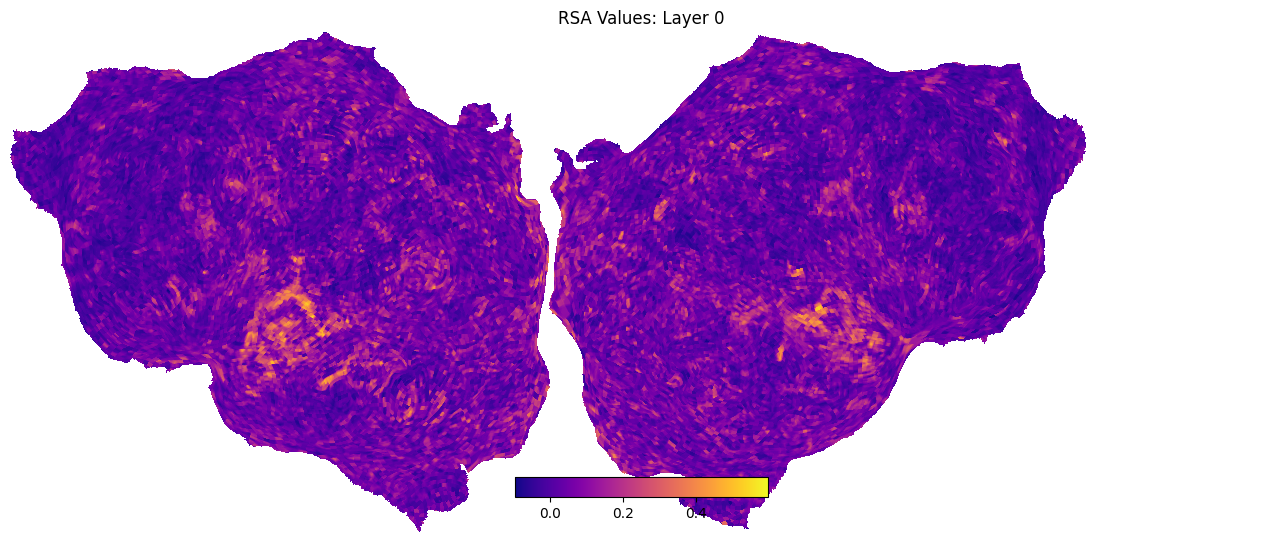

In [ ]:
# Plotting RSA values
output_directory = '/content/drive/MyDrive/10733 - Neuro and AI/charts'
xfmname = f"{subject}_auto"

# Define min and max values for visualization
min_rsa = min(rsa_values)
max_rsa = max(rsa_values)

# Create a volume and plot for RSA values
vol_rsa = cortex.Volume(np.array(rsa_values), subject, xfmname, vmin=min_rsa, vmax=max_rsa, cmap='plasma')
fig = cortex.quickflat.make_figure(vol_rsa, with_rois=False, height=500)
plt.title(f"RSA Values: Layer {layer_index}")
plt.savefig(f"{output_directory}/rsa_plot_layer_{layer_index}.png")
plt.show()

Processed 0 / 81126 voxels (0.00%) for Layer 3
Processed 8112 / 81126 voxels (10.00%) for Layer 3
Processed 16224 / 81126 voxels (20.00%) for Layer 3
Processed 24336 / 81126 voxels (30.00%) for Layer 3
Processed 32448 / 81126 voxels (40.00%) for Layer 3
Processed 40560 / 81126 voxels (50.00%) for Layer 3
Processed 48672 / 81126 voxels (60.00%) for Layer 3
Processed 56784 / 81126 voxels (69.99%) for Layer 3
Processed 64896 / 81126 voxels (79.99%) for Layer 3
Processed 73008 / 81126 voxels (89.99%) for Layer 3
Processed 81120 / 81126 voxels (99.99%) for Layer 3
RSA values for Layer 3 saved to /content/drive/MyDrive/10733 - Neuro and AI/rsa_values_layer_3.pkl


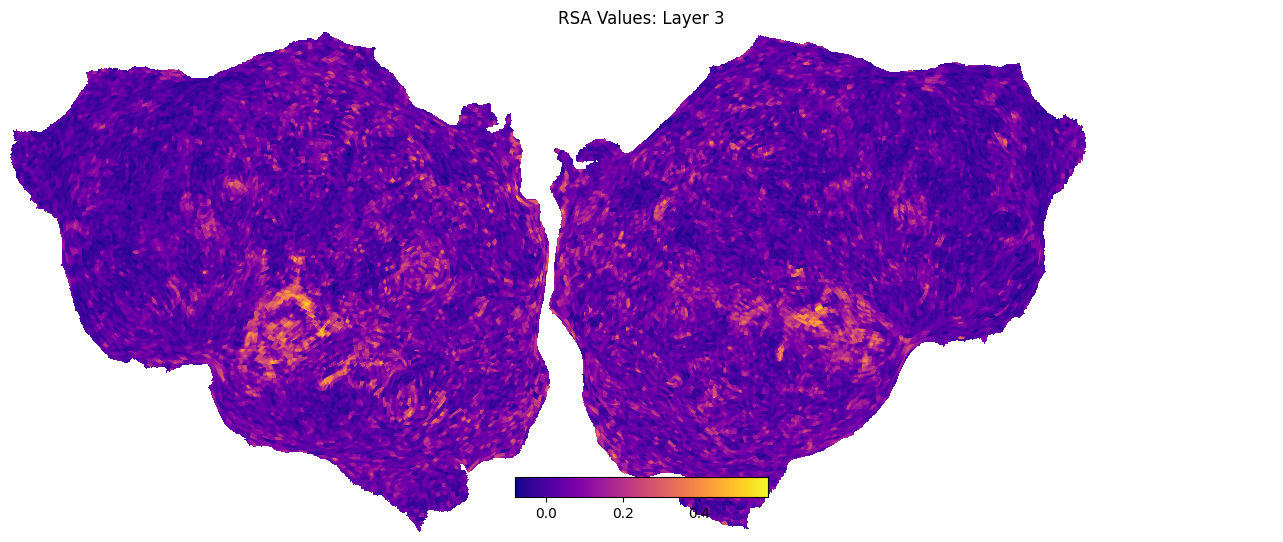

Processed 0 / 81126 voxels (0.00%) for Layer 10
Processed 8112 / 81126 voxels (10.00%) for Layer 10
Processed 16224 / 81126 voxels (20.00%) for Layer 10
Processed 24336 / 81126 voxels (30.00%) for Layer 10
Processed 32448 / 81126 voxels (40.00%) for Layer 10
Processed 40560 / 81126 voxels (50.00%) for Layer 10
Processed 48672 / 81126 voxels (60.00%) for Layer 10
Processed 56784 / 81126 voxels (69.99%) for Layer 10
Processed 64896 / 81126 voxels (79.99%) for Layer 10
Processed 73008 / 81126 voxels (89.99%) for Layer 10
Processed 81120 / 81126 voxels (99.99%) for Layer 10
RSA values for Layer 10 saved to /content/drive/MyDrive/10733 - Neuro and AI/rsa_values_layer_10.pkl


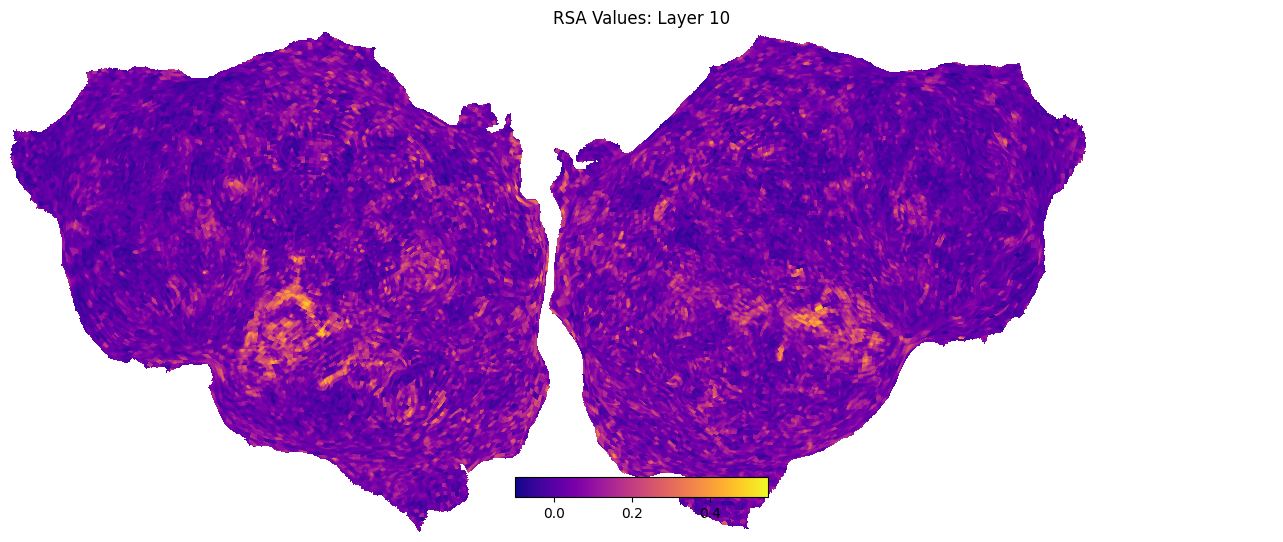

In [ ]:
# All together
subject = 'UTS01'
layer_indices = [3, 10]  # List of layers to process; kept only 3 and 10 because 0 has been already processed; add 0 later
brain_data_key = f"{subject}_wheretheressmoke"

for layer_index in layer_indices:
    aligned_embeddings_key = f"wheretheressmoke_layer_{layer_index}"

    # Load aligned embeddings for the specific story and layer
    story_embeddings_aligned = loaded_aligned_embeddings[aligned_embeddings_key]  # Shape: (time, embedding_dim)
    brain_data = loaded_fmri_full_data[brain_data_key]  # Shape: (time, voxels)

    rsa_values = []
    total_voxels = brain_data.shape[1]
    print_interval = total_voxels // 10  # Print status every 10% of the data

    for voxel_index, voxel_data in enumerate(brain_data.T):
        rsa_val = rsa(voxel_data.reshape(-1, 1), story_embeddings_aligned)
        rsa_values.append(rsa_val)
        if voxel_index % print_interval == 0:
            print(f"Processed {voxel_index} / {total_voxels} voxels ({(voxel_index / total_voxels) * 100:.2f}%) for Layer {layer_index}")

    # Save rsa_values to a pickle file for each layer
    pickle_path = f'/content/drive/MyDrive/10733 - Neuro and AI/rsa_values_layer_{layer_index}.pkl'
    with open(pickle_path, 'wb') as f:
        pickle.dump(rsa_values, f)
    print(f"RSA values for Layer {layer_index} saved to {pickle_path}")

    # Plotting RSA values
    output_directory = '/content/drive/MyDrive/10733 - Neuro and AI/charts'
    xfmname = f"{subject}_auto"
    min_rsa = min(rsa_values)
    max_rsa = max(rsa_values)
    vol_rsa = cortex.Volume(np.array(rsa_values), subject, xfmname, vmin=min_rsa, vmax=max_rsa, cmap='plasma')
    fig = cortex.quickflat.make_figure(vol_rsa, with_rois=False, height=500)
    plt.title(f"RSA Values: Layer {layer_index}")
    plt.savefig(f"{output_directory}/rsa_plot_layer_{layer_index}.png")
    plt.show()

## **References**

- Data: https://openneuro.org/datasets/ds003020/versions/2.0.0
- Kriegeskorte, N., Mur, M., and Bandettini, P. A. (2008). Representational similarity analysis-connecting the branches of systems neuroscience. Frontiers in systems neuroscience, page 4.
- LeBel, A., Wagner, L., Jain, S., Adhikari-Desai, A., Gupta, B., Morgenthal, A., Tang, J., Xu, L., and Huth, A. G. (2023). A natural language fmri dataset for voxelwise encoding models. Scientific Data, 10(1):555.
- FMRI Tutorial 1: https://github.com/HuthLab/speechmodeltutorial
- FMRI Tutorial 2: https://www.cs.cmu.edu/~lwehbe/files/Copy_of_workshop.html